# A cloud of languages

A cloud of languages based on a letter-substitution distances between words (edit-distance, aka Levenshtein distance). Supposedly similar languages should be close to each other.

Most of data comes from this twitter account: https://twitter.com/EuroMinLang

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.manifold as manifold
from IPython.core.display import display, HTML

In [2]:
def plausible(c1,c2):
    # Returns plausibility of change from letter c1 to letter c2
    # αβγδεικλμνοπρςστυχψ абвгдежзийклмнопрстухцчшъыьэяј
    cl = 0.2 # Low cost
    cm = 0.5 # Mid
    ch = 0.8 # High
    groups = {'aàáâãäåāăæ':cl, 'eēėěèéêëё':cl, 'oøòóôöӧ':cl, 'uùúûüūų':cl, 'iіìíı':cl, 'yӱý':cl,
              'lḷľłl':cl, 'zźżž':cl, 'cçĉč':cl, 'śŝşšș':cl, 'ĝğġ':cl, 'nñņњҥ':cl, 'kķ':cl,
              'dðď':cm, 'hħ': cm, 'wv':cm, 
              'aoeiyæaàáâãäåāăæeēėěèéêëёoøòóôöӧiіìíıyӱý':cm,
              'ўl':ch, 'bv':ch, 'gkc':ch, 'csz':ch, 'pf':ch}
    for g,val in groups.items():
        if c1 in g and c2 in g:
            return val
    return 1

print(plausible('a','b'))
print(plausible('a','e'))
print(plausible('a','ä'))

1
0.5
0.2


In [3]:
# Edit-distance (dynamic programming)
def edit_distance(s1, s2, smart=True):
    # Levenschtein distance (edit distance).
    # If smart=True, considers some changes more likely.
    n1 = len(s1)
    n2 = len(s2)
    mem = [[0 for j in range(n2+1)] for i in range(n1+1)]
    # mem is Number of edits so far
    for i in range(n1+1):
        for j in range(n2+1):
            if   i==0: mem[i][j] = j
            elif j==0: mem[i][j] = i
            elif s1[i-1]==s2[j-1]: mem[i][j] = mem[i-1][j-1]
            else:
                if not smart:
                    cost = 1
                else:
                    cost = plausible(s1[i-1], s2[j-1])
                mem[i][j] = min([cost+mem[i-1][j-1], 1+mem[i-1][j], 1+mem[i][j-1]])
    return mem[n1][n2]

edit_distance('hlavä12345dd', 'golova12345')

4.7

In [4]:
# Read the data
with open('parallel_vocabs.txt', 'r', encoding="utf8") as f:
    lines = f.readlines()

In [5]:
# All symbols used in this vocab
chars = set()
for s in lines:
    for c in s.lower():
        chars.add(c)
print(''.join(sorted(list(chars))))


 '(),-/4@_abcdefghijklmnopqrstuvwxyzàáâãäåæçèéêëìíðñòóôöøùúûüýāăĉčďēėěĝğġħıķľłņśŝşšūųźżžșαβγδεικλμνοπρςστυχψабвгдежзийклмнопрстухцчшъыьэяёіјњўҥӧӱḷ


In [6]:
# Put data in boxes

prefixes = ['Mouse face', 'Pig face', 'Rabbit face', 'Cow face', 'Pig face', 'Frog face', 
            'Chicken', 'Wolf face', 'Fox face', 'Dog face', 'Cat face', 'Bear face', 'Bird', 
            'Horse face', 'Honeybee', 'Butterfly', 'Deer', 'Snake', 'Fish', 'Duck', 'Goat',
           'Chipmunk', 'Monkey', 'Boar', 'Otter', 'Beaver', 'Snail', 'Spider', 'Ant',
           'Swan', 'Fly', 'Owl', 'Hedgehog', 'Sheep']
box = {s : s.split(' ')[0].lower() for s in prefixes}
box['Chicken'] = 'hen'
box['Baby chick'] = 'chicken'
box['Lady beetle'] = 'ladybug'

row1 = 'а б в г д е ж з и к л м н о п р с т у ф х ц ч ш ў α β γ δ ε ζ ι κ λ μ ν ο π ρ σ τ υ φ ξ χ ς ћ'.split(' ')
row2 = 'a b v g d e ž z i k l m n o p r s t u f h c č š ł a b g d e z i k l m n o p r s t u f x h s c'.split(' ')
translit = {row1[i] : row2[i] for i in range(len(row1))}

summary = {}    
bag = {}

lang = ''
head_flag = False
for s in lines:
    s = s.strip()  # Remove leading and trailing spaces
    if not s: continue # Skip empty lines
    if s[0]=='@':  # New language
        author = s
        head_flag = True # Expect new language
        continue
    if head_flag:
        if s[-5:]=='(big)': # For now isn't used, but may be useful for vizualization later
            big = True
            s = s[:-5].strip()
        else:
            big = False
        lang = s
        head_flag = False
        bag[lang] = bag.get(lang, {}) # In case the language is present more than once
        continue
    identified = False
    for key,value in box.items():        
        if s.find(key)==0:
            word = s[len(key):].lower()
            word = word.split(',')[0].split('/')[0].strip() # If more than one variant, pick the first one
            word = ''.join([translit[c] if c in translit else c for c in word ])
            bag[lang][value] = word
            summary[value] = summary.get(value, 0)+1
            identified = True
    if not identified:
        #print(s)
        pass
    
#print(bag)
print(summary)

{'dog': 72, 'cat': 72, 'mouse': 72, 'rabbit': 72, 'bear': 72, 'cow': 72, 'pig': 72, 'frog': 72, 'hen': 12, 'chicken': 11, 'bird': 72, 'wolf': 72, 'fox': 72, 'horse': 13, 'honeybee': 72, 'butterfly': 72, 'deer': 11, 'ladybug': 13, 'snake': 13, 'fish': 73, 'duck': 12, 'chipmunk': 11, 'goat': 12, 'monkey': 1, 'boar': 1, 'otter': 1, 'beaver': 1, 'snail': 1, 'ant': 3, 'spider': 3, 'fly': 2, 'sheep': 2, 'owl': 2, 'hedgehog': 2, 'swan': 1}


In [7]:
# Calculate distance matrix

lang_list = list(bag.keys())
nlangs = len(lang_list)
dist = np.zeros((nlangs,nlangs))

wordlist = ['dog', 'cat', 'rabbit', 'cow', 'pig', 'wolf', 'fox', 'bear', 'frog', 'bird', 
            'honeybee', 'butterfly', 'fish']
# Rabbit may be problematic because of the rabbit/hare split


for l1 in range(nlangs):
    print(lang_list[l1], end=' ')
    for l2 in range(l1):
        lang1 = lang_list[l1]
        lang2 = lang_list[l2]
        x = 0
        n = 0        
        for word in wordlist:
            if word in bag[lang2].keys() and word in bag[lang1].keys():
                x += edit_distance(bag[lang1][word], bag[lang2][word])
                n += 1
        dist[l1,l2] = x/n
        
# Post-processing
dist = dist + dist.T # Make symmetric
#dist

Sulrsilvan Lengadocian Aghul Sylt Frisian Lemosin Nissart Catalan Fenouillèdes Occitan Manx Sardinian Cornish Gallo Breton French Vallader Saintongeais Meadow Mari Gardenese Lothringian Sicilian Walloon Lombard Neapolitan Piedmontese Vivaro Genoese Welsh Irish Arpitan West Frisian Scots Asturian Corsican Falemos Aragonese Galician Alsatian Luxembourgish Basque Russian English Portuguese Castilian Icelandic Danish Swedish Finnish Estonian Latvian Lithuanian Belarusian Ukrainian Dutch German Italian Czech Slovak Polish Hungarian Slovenian Croatian Serbian Romanian Bulgarian Macedonian Albanian Greek Turkish Maltese Lower Sorbian Upper Sorbian Kashubian 

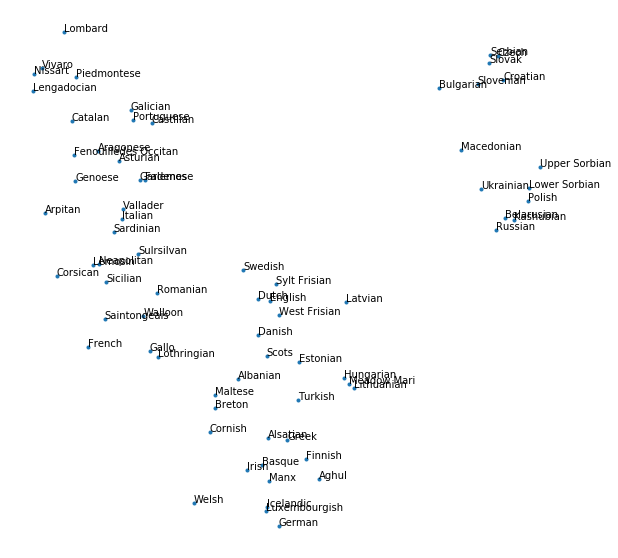

In [8]:
# LLE Projection

emb = manifold.LocallyLinearEmbedding(n_components=2, n_neighbors=len(lang_list)-1, method='ltsa')
y = emb.fit_transform(dist)

plt.figure(figsize=(10,10), facecolor='white');
plt.axis('off');
plt.plot(y[:,0], y[:,1], '.');
for i in range(len(lang_list)):
    plt.text(y[i,0], y[i,1], lang_list[i])

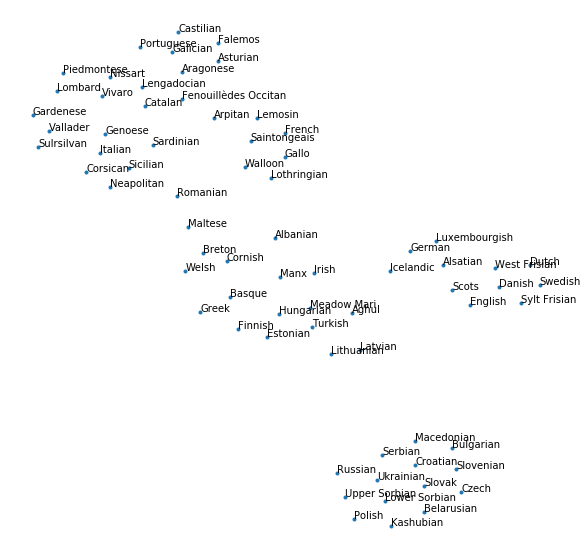

In [16]:
# tSNE Projection - looks horrible for some reason (parameters?)
emb = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=18)

# MDS - even more horrible
#emb = manifold.MDS(n_components=2, max_iter=1000, n_init=1, dissimilarity='precomputed')

# Spectral embedding - finicky, unpleasant
#emb = manifold.SpectralEmbedding(n_components=2, n_neighbors=30)

y = emb.fit_transform(dist)

plt.figure(figsize=(10,10), facecolor='white');
plt.axis('off');
plt.plot(y[:,0], y[:,1], '.');
for i in range(len(lang_list)):
    plt.text(y[i,0], y[i,1], lang_list[i])

In [10]:
# Organize languages in a meaningful sequence

#emb = manifold.TSNE(n_components=1, init='pca', random_state=0, perplexity=40)
emb = manifold.SpectralEmbedding(n_components=1, n_neighbors=30)
rank = np.argsort(emb.fit_transform(dist).squeeze().tolist())
print([lang_list[i] for i in rank])

['Vivaro', 'Nissart', 'Lengadocian', 'Catalan', 'Fenouillèdes Occitan', 'Arpitan', 'Genoese', 'Portuguese', 'Corsican', 'Aragonese', 'Lombard', 'Galician', 'Lemosin', 'Italian', 'Neapolitan', 'Sicilian', 'Asturian', 'Piedmontese', 'Falemos', 'French', 'Vallader', 'Sardinian', 'Saintongeais', 'Gardenese', 'Walloon', 'Gallo', 'Castilian', 'Sulrsilvan', 'Romanian', 'Lothringian', 'Maltese', 'Breton', 'Welsh', 'Cornish', 'Swedish', 'Basque', 'Greek', 'Albanian', 'Manx', 'Danish', 'Dutch', 'Sylt Frisian', 'English', 'Alsatian', 'Irish', 'German', 'Luxembourgish', 'West Frisian', 'Icelandic', 'Aghul', 'Finnish', 'Turkish', 'Estonian', 'Scots', 'Hungarian', 'Meadow Mari', 'Lithuanian', 'Latvian', 'Bulgarian', 'Czech', 'Slovak', 'Serbian', 'Slovenian', 'Croatian', 'Russian', 'Ukrainian', 'Belarusian', 'Macedonian', 'Kashubian', 'Upper Sorbian', 'Lower Sorbian', 'Polish']


In [11]:
# Table

# Create a data frame
df = pd.DataFrame()
for i in range(nlangs):
    name = lang_list[rank[i]]    
    for word in wordlist:
        if word in bag[name].keys():
            df.loc[name,word] = bag[name][word]
            
display(HTML(df.to_html()))

,dog,cat,rabbit,cow,pig,wolf,fox,bear,frog,bird,honeybee,butterfly,fish
Vivaro,chan,chat,conilh,vacha,puèrc,lop,vorp,ors,rana,aucel,abelha,parpalhon,pèis
Nissart,can,cat,coniu,vaca,poarc,lop,vorp,ors,granolha,auceu,abelha,parpalhon,pei
Lengadocian,can,cat,conilh,vaca,pòrc,lop,rainal,ors,granhòta,aucèl,abelha,parpalhòl,peis
Catalan,gos,gat,conill,vaca,porc,llop,guineu,ós,granota,ocell,abella,papallona,peix
Fenouillèdes Occitan,gos,gat,lhèbre,vaca,pòrc,lhop,mandra,ors,granhòta,ausèl,abelha,parpalhon,peis
Arpitan,chin,chat,counél,vache,puerc,lop,renârd,ôrs,grenolye,usél,avelye,parpelyon,pêsson
Genoese,can,gatto,coniggio,vacca,pòrco,lô,vorpe,orso,baggio,oxello,avia,parpaggia,pescio
Portuguese,cão,gato,coelho,vaca,porco,lobo,raposa,urso,sapo,pássaro,abelha,borboleta,peixe
Corsican,cane,ghjattu,cunigliu,vacca,porcu,lupu,volpe,ursu,granochja,acellu,apa,farfalla,pèsciu
Aragonese,can,gato,conello,vaca,cochín,lupo,rabosa,onso,granota,muixón,abella,paixarela,peix


In [12]:
with open('vocab_table.html', 'w', encoding='UTF-8') as f:
    f.write('<!DOCTYPE html><html><head></head><body>')
    f.write(df.to_html())
    f.write('</body></html?')

In [13]:
df.loc[['Luxembourgish', 'Lothringian']]

,dog,cat,rabbit,cow,pig,wolf,fox,bear,frog,bird,honeybee,butterfly,fish
Luxembourgish,hond,kaz,kanéngchen,kou,schwäin,wollef,fuuss,bier,fräsch,villchen,bei,päiperlek,fësch
Lothringian,schin,schätt,läpin,väsch,puchë,lu,rnà,urs,goernùi,ohë,muchott,pàpion,puchon


Template

```
Dog face 
Cat face 
Mouse face 
Rabbit face 
Bear face 
Cow face 
Pig face 
Frog face 
Wolf face 
Fox face 
Bird 
Fish 
Butterfly 
Honeybee 
```